In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32 #number of images in 1 batch
IMAGE_SIZE = 256
CHANNELS=3 # RGB
EPOCHS=50 #Total passes

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1): # taking 1 sample badge
    print(image_batch.shape) #(BATCH_SIZE, H, W, Channels)
    print(labels_batch.numpy()) # labels_batch is a tensor, convert to numpy, label 1, 2, 3 for 3 classes

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


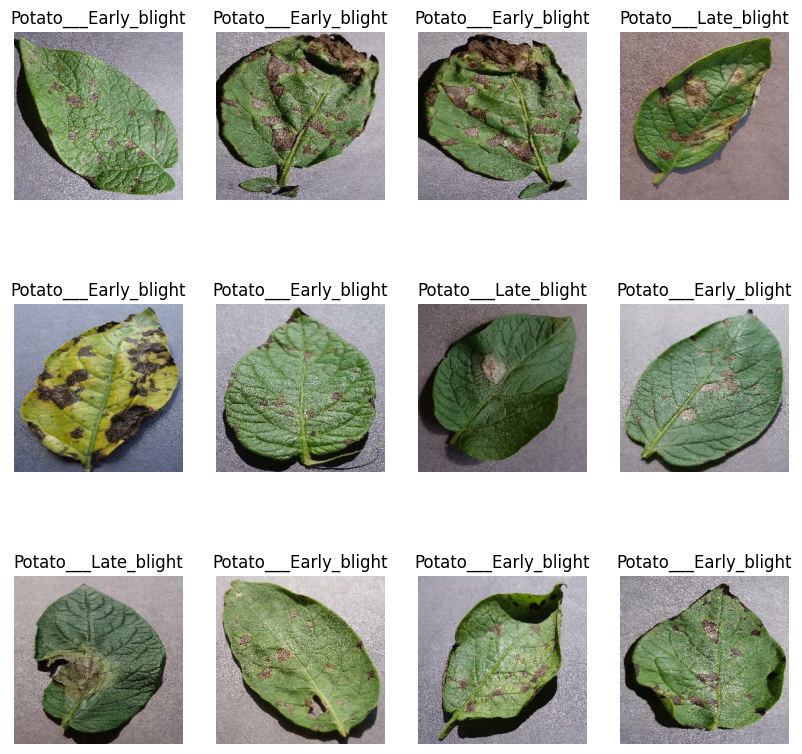

In [8]:
plt.figure(figsize=(10, 10)) # Increase the size of image
for image_batch, labels_batch in dataset.take(1):
    for i in range(12): # printing 12
        ax = plt.subplot(3, 4, i + 1) #the figure has 3 rows, 4 columns, and this plot is the (i+1)th plot.
        plt.imshow(image_batch[i].numpy().astype("uint8")) # prints the image, numpy, float to uint8
        plt.title(class_names[labels_batch[i]]) # attaching class name
        plt.axis("off") # hiding axis

In [9]:
len(dataset) #as 68 * BATCH_SIZE = total imgs

68

In [10]:
train_size = 0.8  # 80 percent of total
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54) # take after 56
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6) # 10 percent of total
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6) # 10 percent of total
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000): # same function packed
    assert (train_split + test_split + val_split) == 1 # enforce this check, for both default and passed parameters

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [18]:
len(train_ds) # Actually, images are len * 32


54

In [19]:
len(val_ds)


6

In [20]:
len(test_ds)


8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy().shape) # dimensions of data
    #print(image_batch[0].numpy()) # how data looks
    # normalize by dividing with 255
    print(image_batch[0].numpy()/255) # all between 0 and 1
  # Done for dataset below

(256, 256, 3)
[[[0.6313726  0.57254905 0.5921569 ]
  [0.5764706  0.5176471  0.5372549 ]
  [0.56078434 0.5019608  0.52156866]
  ...
  [0.63529414 0.5568628  0.5921569 ]
  [0.6392157  0.56078434 0.59607846]
  [0.6431373  0.5647059  0.6       ]]

 [[0.57254905 0.5137255  0.53333336]
  [0.5764706  0.5176471  0.5372549 ]
  [0.5686275  0.50980395 0.5294118 ]
  ...
  [0.6392157  0.56078434 0.59607846]
  [0.6431373  0.5647059  0.6       ]
  [0.64705884 0.5686275  0.6039216 ]]

 [[0.5686275  0.50980395 0.5294118 ]
  [0.5764706  0.5176471  0.5372549 ]
  [0.5764706  0.5176471  0.5372549 ]
  ...
  [0.63529414 0.5568628  0.5921569 ]
  [0.6392157  0.56078434 0.59607846]
  [0.6392157  0.56078434 0.59607846]]

 ...

 [[0.7058824  0.6509804  0.6509804 ]
  [0.7137255  0.65882355 0.65882355]
  [0.7137255  0.65882355 0.65882355]
  ...
  [0.68235296 0.62352943 0.6431373 ]
  [0.67058825 0.6117647  0.6313726 ]
  [0.6627451  0.6039216  0.62352943]]

 [[0.6784314  0.62352943 0.62352943]
  [0.7058824  0.6509804

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255),
]) # keras layer, rescale to normalize, resize in case images passed are not 256*256

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
]) # generating additional images by flipping and rotating, as input can be in any way

In [31]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Chirag Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds, 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4257 - loss: 0.9557 - val_accuracy: 0.5938 - val_loss: 0.8207
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 951ms/step - accuracy: 0.6673 - loss: 0.7557 - val_accuracy: 0.7865 - val_loss: 0.4147
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8235 - loss: 0.4011 - val_accuracy: 0.9115 - val_loss: 0.2724
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 991ms/step - accuracy: 0.8701 - loss: 0.3170 - val_accuracy: 0.9010 - val_loss: 0.2344
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 921ms/step - accuracy: 0.8857 - loss: 0.2632 - val_accuracy: 0.8906 - val_loss: 0.2781
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 891ms/step - accuracy: 0.9032 - loss: 0.2369 - val_accuracy: 0.8906 - val_loss: 0.2752
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 897ms/step - accuracy: 0.9113 - loss: 0.1998 - val_accuracy: 0.9427 - val_loss: 0.2257
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 895ms/step - accuracy: 0.9320 - loss: 0.1896 - val_accuracy: 

In [36]:
scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9791 - loss: 0.0341


In [37]:
scores

[0.04013120010495186, 0.98046875]

In [38]:
history

In [39]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 54}

In [40]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [41]:
type(history.history['loss'])


list

In [42]:
len(history.history['loss'])


50

In [43]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9099466800689697,
 0.6914166808128357,
 0.383578896522522,
 0.2974016070365906,
 0.2607273757457733]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

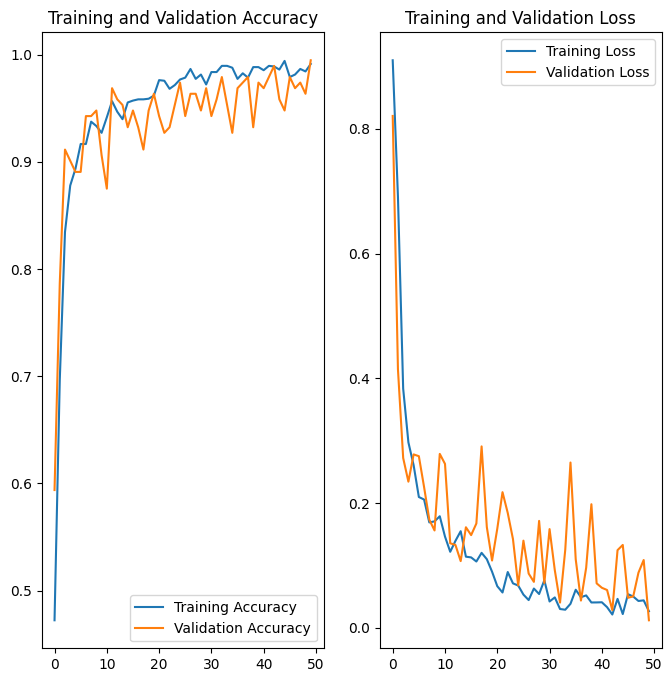

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
predicted label: Potato___Late_blight


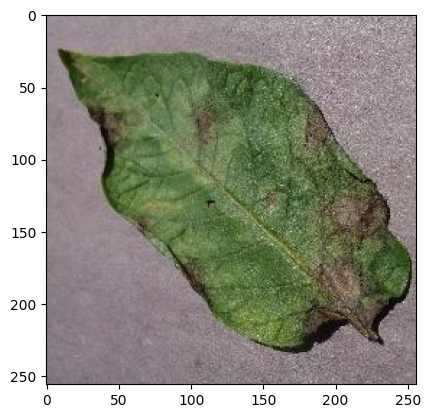

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


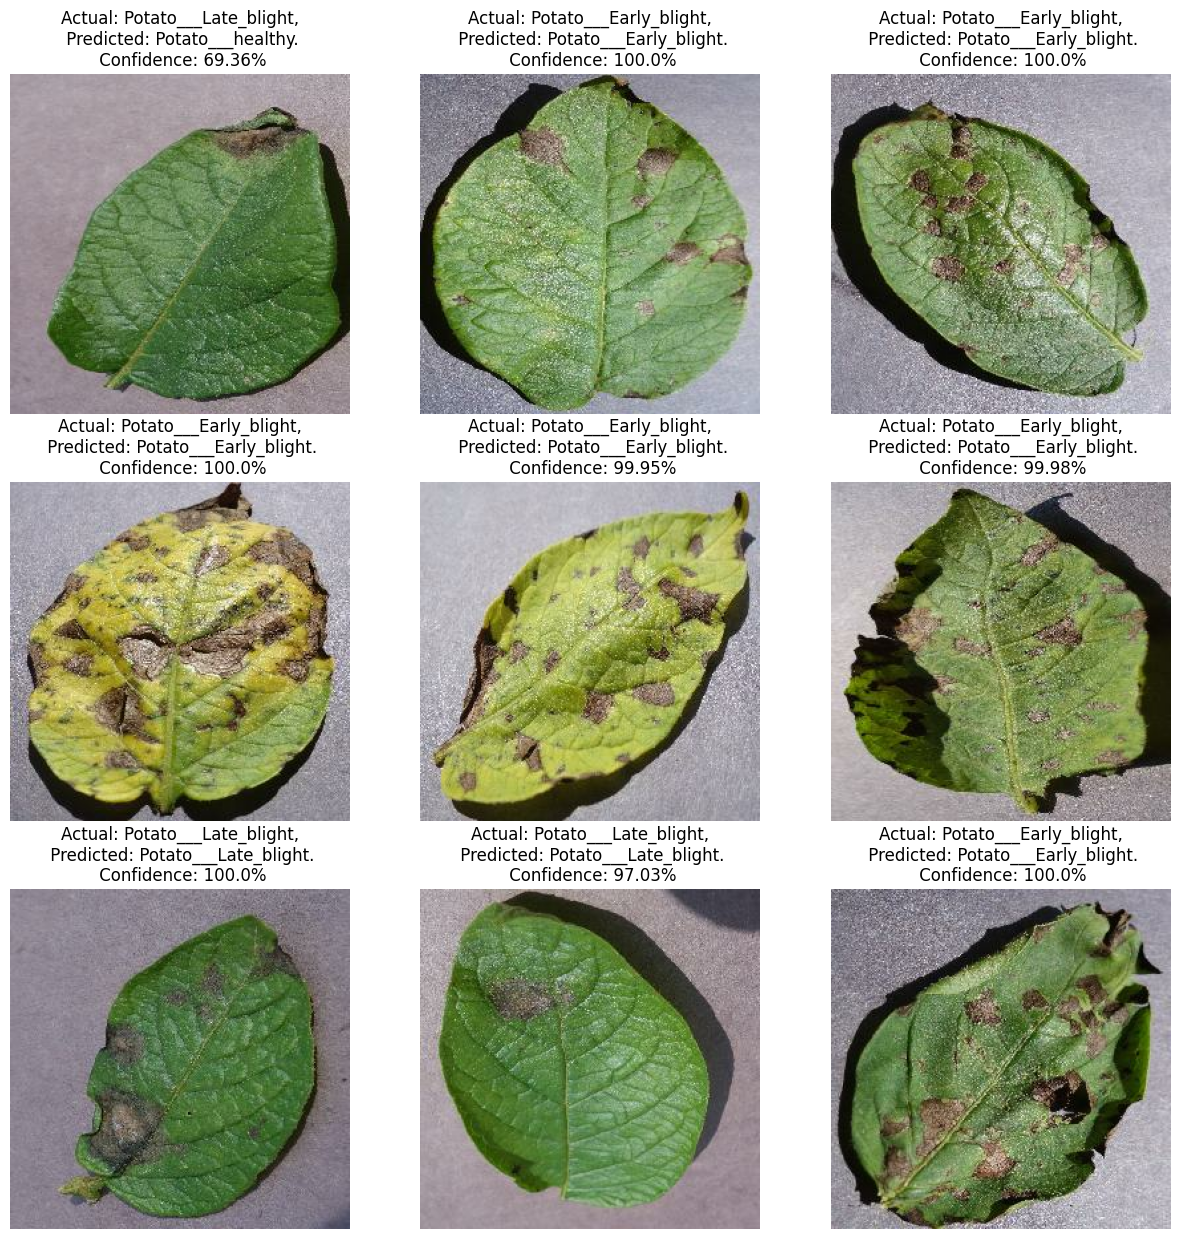

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [52]:
model.save("../potatoes.keras")

In [53]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [ ]:
y_pred = cnn_model2.predict(X_test)
y_pred.round(2)